In [36]:
# =======================
# 라이브러리
# =======================
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import seaborn as sns

# 한글 폰트 설정 (Windows 기준)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False



# 경로 설정
DATA_DIR = Path("data/raw_data")
feat_path = DATA_DIR / "secom.data"
label_path = DATA_DIR / "secom_labels.data"

# 컬럼명 읽기 (secom.names 참고 가능)
n_features = 590  # 실제 590개 센서지만 1개는 timestamp용이거나 결측 가능
col_names = [f"Sensor_{i+1}" for i in range(590)]

# 데이터 로드
X = pd.read_csv(feat_path, sep=' ', header=None, names=col_names)
y = pd.read_csv(label_path, sep=' ', header=None, names=['Pass_Fail', 'Timestamp'])

print("데이터 크기:", X.shape)
print("라벨 크기:", y.shape)
X.head(3)


데이터 크기: (1567, 590)
라벨 크기: (1567, 2)


,Sensor_1,Sensor_2,Sensor_3,Sensor_4,Sensor_5,Sensor_6,Sensor_7,Sensor_8,Sensor_9,Sensor_10,...,Sensor_581,Sensor_582,Sensor_583,Sensor_584,Sensor_585,Sensor_586,Sensor_587,Sensor_588,Sensor_589,Sensor_590
0,3030.93,2564.00,2187.7333,1411.1265,1.3602,100.0,97.6133,0.1242,1.5005,0.0162,...,NaN,NaN,0.5005,0.0118,0.0035,2.3630,NaN,NaN,NaN,NaN
1,3095.78,2465.14,2230.4222,1463.6606,0.8294,100.0,102.3433,0.1247,1.4966,-0.0005,...,0.0060,208.2045,0.5019,0.0223,0.0055,4.4447,0.0096,0.0201,0.0060,208.2045
2,2932.61,2559.94,2186.4111,1698.0172,1.5102,100.0,95.4878,0.1241,1.4436,0.0041,...,0.0148,82.8602,0.4958,0.0157,0.0039,3.1745,0.0584,0.0484,0.0148,82.8602


In [28]:
# 결측치(NA) 확인
missing_ratio = X.isna().mean() * 100
print("결측 비율이 50% 이상인 센서 수:", (missing_ratio > 50).sum())

# 기본 통계량
X.describe().T.head(10)


결측 비율이 50% 이상인 센서 수: 28


,count,mean,std,min,25%,50%,75%,max
Sensor_1,1561.0,3014.452896,73.621787,2743.2400,2966.2600,3011.4900,3056.6500,3356.3500
Sensor_2,1560.0,2495.850231,80.407705,2158.7500,2452.2475,2499.4050,2538.8225,2846.4400
Sensor_3,1553.0,2200.547318,29.513152,2060.6600,2181.0444,2201.0667,2218.0555,2315.2667
Sensor_4,1553.0,1396.376627,441.691640,0.0000,1081.8758,1285.2144,1591.2235,3715.0417
Sensor_5,1553.0,4.197013,56.355540,0.6815,1.0177,1.3168,1.5257,1114.5366
Sensor_6,1553.0,100.000000,0.000000,100.0000,100.0000,100.0000,100.0000,100.0000
Sensor_7,1553.0,101.112908,6.237214,82.1311,97.9200,101.5122,104.5867,129.2522
Sensor_8,1558.0,0.121822,0.008961,0.0000,0.1211,0.1224,0.1238,0.1286
Sensor_9,1565.0,1.462862,0.073897,1.1910,1.4112,1.4616,1.5169,1.6564
Sensor_10,1565.0,-0.000841,0.015116,-0.0534,-0.0108,-0.0013,0.0084,0.0749


In [29]:
y['Pass_Fail'].value_counts()

Pass_Fail
-1    1463
 1     104
Name: count, dtype: int64

In [30]:
# 중앙값으로 결측치 대체
X = X.fillna(X.median())

# 대체 완료 확인
print("결측치 남은 컬럼 수:", X.isna().sum().gt(0).sum())


결측치 남은 컬럼 수: 0


In [31]:
data = X.copy()
data['Pass_Fail'] = y['Pass_Fail']

# 센서별 상관계수 계산
corr = data.corr()['Pass_Fail'].sort_values(ascending=False)
corr.head(10)


Pass_Fail     1.000000
Sensor_60     0.156008
Sensor_104    0.151230
Sensor_511    0.131662
Sensor_349    0.130807
Sensor_432    0.119936
Sensor_435    0.111312
Sensor_431    0.109115
Sensor_22     0.108333
Sensor_436    0.108260
Name: Pass_Fail, dtype: float64

Feature shape: (1567, 590)
Label shape: (1567, 2)
전체 결측 비율: 4.54%
총 변수 개수: 590
총 샘플 수: 1567
결측치 포함 비율(평균): 4.54%


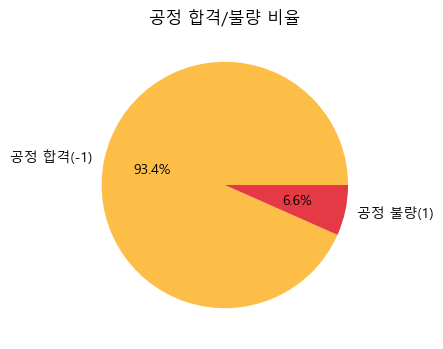

Pass_Fail
-1    93.363114
 1     6.636886
Name: proportion, dtype: float64


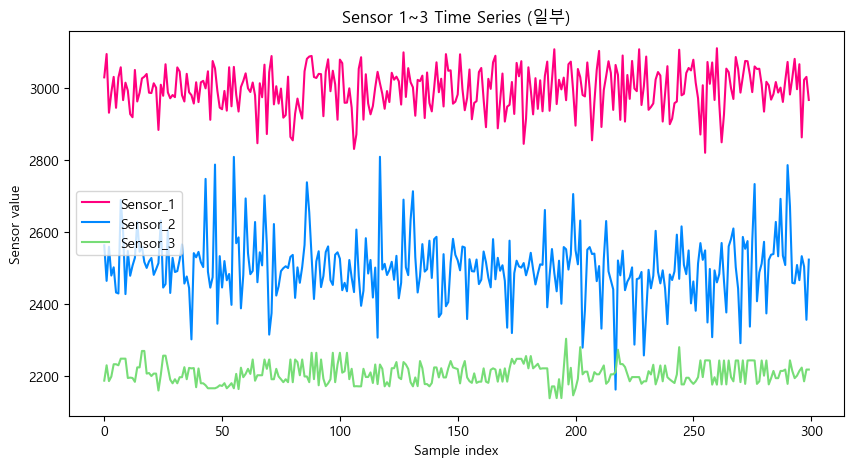

불량과 상관 높은 센서 TOP10:
 Sensor_60     0.155771
Sensor_104    0.151196
Sensor_511    0.131587
Sensor_349    0.130108
Sensor_432    0.120304
Sensor_435    0.111609
Sensor_431    0.109569
Sensor_436    0.108573
Sensor_22     0.107997
Sensor_29     0.106767
Name: Pass_Fail, dtype: float64


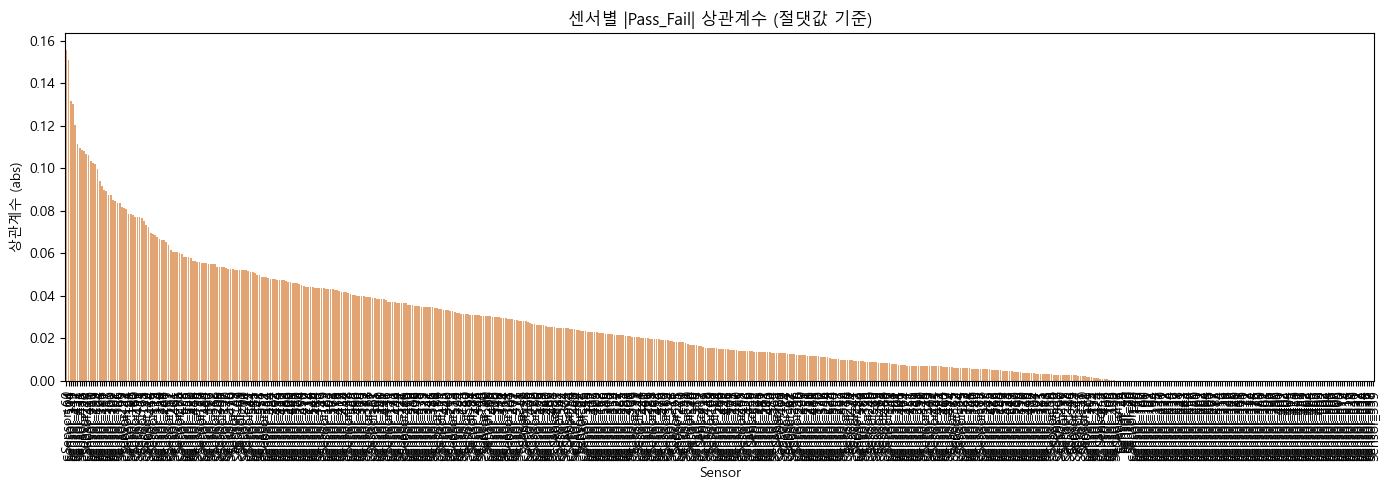

In [32]:
# =======================
# 1. 라이브러리 및 경로 설정
# =======================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

# 경로
DATA_DIR = Path("data/raw_data")
feat_path = DATA_DIR / "secom.data"
label_path = DATA_DIR / "secom_labels.data"

# =======================
# 2. 데이터 로드
# =======================
col_names = [f"Sensor_{i+1}" for i in range(590)]
X = pd.read_csv(feat_path, sep=' ', header=None, names=col_names)
y = pd.read_csv(label_path, sep=' ', header=None, names=['Pass_Fail', 'Timestamp'])

print("Feature shape:", X.shape)
print("Label shape:", y.shape)

# =======================
# 3. 결측치 현황
# =======================
missing_ratio = X.isna().mean().mean() * 100
print(f"전체 결측 비율: {missing_ratio:.2f}%")

# Profile Table 스타일 요약
print("총 변수 개수:", X.shape[1])
print("총 샘플 수:", X.shape[0])
print("결측치 포함 비율(평균):", f"{missing_ratio:.2f}%")

# =======================
# 4. 결측치 대체 (평균값으로)
# =======================
X = X.fillna(X.mean())

# =======================
# 5. 라벨 분포 (Pie Chart)
# =======================
label_counts = y['Pass_Fail'].value_counts(normalize=True) * 100
plt.figure(figsize=(4,4))
plt.pie(label_counts, labels=['공정 합격(-1)', '공정 불량(1)'], 
        autopct='%1.1f%%', colors=['#FDBE47','#E63946'])
plt.title('공정 합격/불량 비율')
plt.show()

print(label_counts)

# =======================
# 6. 일부 센서 시각화 (Sensor 1~3)
# =======================
plt.figure(figsize=(10,5))
for i, color in zip(range(3), ['#FF007F', '#0088FF', '#77DD77']):
    plt.plot(X.iloc[:, i].values[:300], label=f'Sensor_{i+1}', color=color)
plt.legend()
plt.title('Sensor 1~3 Time Series (일부)')
plt.xlabel('Sample index')
plt.ylabel('Sensor value')
plt.show()

# =======================
# 7. 상관성 분석
# =======================
data = X.copy()
data['Pass_Fail'] = y['Pass_Fail']

# 각 센서와 불량 여부 간의 상관계수 계산
corr_series = data.corr()['Pass_Fail'].drop('Pass_Fail').abs().sort_values(ascending=False)

# 상위 10개 센서 출력
top10_sensors = corr_series.head(10)
print("불량과 상관 높은 센서 TOP10:\n", top10_sensors)

# 시각화
plt.figure(figsize=(14,5))
sns.barplot(x=corr_series.index, y=corr_series.values, color='#F4A261')
plt.xticks(rotation=90)
plt.title('센서별 |Pass_Fail| 상관계수 (절댓값 기준)')
plt.ylabel('상관계수 (abs)')
plt.xlabel('Sensor')
plt.tight_layout()
plt.show()


In [33]:
from xgboost import XGBClassifier
print("XGBoost import OK")


XGBoost import OK


SMOTE 후 라벨 분포:
Pass_Fail
0    1023
1    1023
Name: count, dtype: int64
===== Classification Report =====
              precision    recall  f1-score   support

       정상(0)      0.943     0.936     0.940       440
       불량(1)      0.176     0.194     0.185        31

    accuracy                          0.887       471
   macro avg      0.560     0.565     0.562       471
weighted avg      0.892     0.887     0.890       471



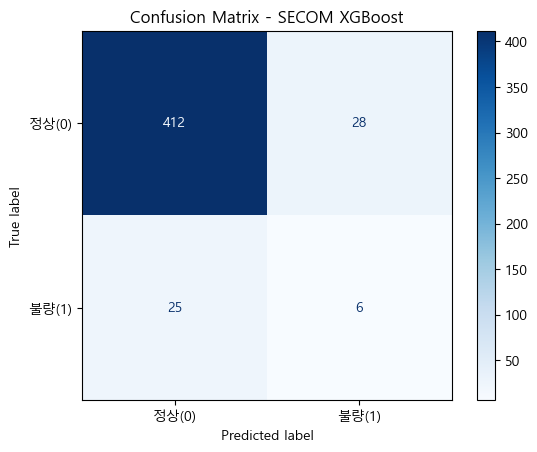

In [ ]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1) 라벨을 0/1로 변환
# SECOM: -1(정상) -> 0, 1(불량) -> 1
y_bin = y['Pass_Fail'].replace({-1: 0, 1: 1})

# 2) 상관계수 상위 20개 센서 선택
top_features = corr_series.head(20).index.tolist()
X_sel = X[top_features]

# 3) train/test 분할 
X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y_bin, test_size=0.3, random_state=42, stratify=y_bin
)

# 4) 스케일링
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5) SMOTE로 불균형 보정
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("SMOTE 후 라벨 분포:")
print(y_train_res.value_counts())

# 6) XGBoost 학습
model = XGBClassifier(
    n_estimators=200,
    max_depth=4,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)
model.fit(X_train_res, y_train_res)

# 7) 평가
y_pred = model.predict(X_test_scaled)

print("===== Classification Report =====")
# 다시 사람이 이해하기 쉽게 0->정상, 1->불량이라고 생각하면 됨
print(classification_report(y_test, y_pred, digits=3,
                            target_names=['정상(0)', '불량(1)']))

cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['정상(0)', '불량(1)'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix - SECOM XGBoost")
plt.show()


선택된 센서 수: 39개
['Sensor_60', 'Sensor_104', 'Sensor_511', 'Sensor_349', 'Sensor_432', 'Sensor_435', 'Sensor_431', 'Sensor_436', 'Sensor_22', 'Sensor_29']
SMOTE 후 라벨 분포:
Pass_Fail
0    1023
1    1023
Name: count, dtype: int64


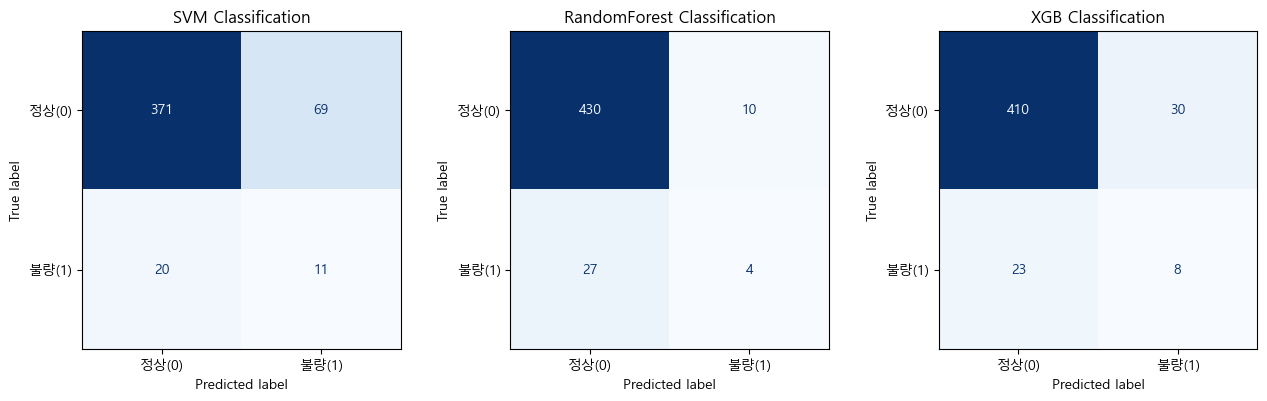


===== 모델별 성능 요약 =====


,정확도,불량재현율(Recall_1),불량정밀도(Precision_1),불량F1
SVM,0.811,0.355,0.138,0.198
RandomForest,0.921,0.129,0.286,0.178
XGB,0.887,0.258,0.211,0.232


In [ ]:
# =======================
# 라벨을 0/1로 변환
# =======================
y_bin = y['Pass_Fail'].replace({-1: 0, 1: 1})

# =======================
# ③ Feature Selection
selected_features = corr_series[corr_series >= 0.069].index.tolist()
print(f"선택된 센서 수: {len(selected_features)}개")
print(selected_features[:10])

# 선택된 피처만 가져오고 결측 대체 한번더
X_sel = X[selected_features].copy()
X_sel = X_sel.fillna(X_sel.mean())  

# =======================
# 데이터 분할 (Train/Test)
# =======================
X_train, X_test, y_train, y_test = train_test_split(
    X_sel, y_bin, test_size=0.3, random_state=42, stratify=y_bin
)

# =======================
# ④ 정규화 (Normalization)
# =======================
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# =======================
# SMOTE (불균형 데이터 처리)
# =======================
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)

print("SMOTE 후 라벨 분포:")
print(y_train_res.value_counts())

# =======================
# ⑤ 모델링: SVM / RandomForest / XGB
# =======================
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd

models = {
    "SVM": SVC(kernel='rbf', C=1, gamma='scale', random_state=42),
    "RandomForest": RandomForestClassifier(n_estimators=200, random_state=42),
    "XGB": XGBClassifier(
        n_estimators=200, max_depth=4, learning_rate=0.05,
        subsample=0.8, colsample_bytree=0.8, random_state=42, eval_metric='logloss'
    )
}

results = {}
for name, model in models.items():
    model.fit(X_train_res, y_train_res)
    y_pred = model.predict(X_test_scaled)
    cm = confusion_matrix(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results[name] = {"cm": cm, "report": report}

# =======================
# 결과 비교 시각화
# =======================
fig, axes = plt.subplots(1, 3, figsize=(13, 4))
for ax, (name, result) in zip(axes, results.items()):
    disp = ConfusionMatrixDisplay(
        confusion_matrix=result["cm"],
        display_labels=["정상(0)", "불량(1)"]
    )
    disp.plot(ax=ax, cmap="Blues", colorbar=False)
    ax.set_title(f"{name} Classification")

plt.tight_layout()
plt.show()

# =======================
# 성능 요약 테이블
# =======================
summary = pd.DataFrame({
    name: {
        "정확도": r["report"]["accuracy"],
        "불량재현율(Recall_1)": r["report"]["1"]["recall"],
        "불량정밀도(Precision_1)": r["report"]["1"]["precision"],
        "불량F1": r["report"]["1"]["f1-score"]
    } for name, r in results.items()
}).T

print("\n===== 모델별 성능 요약 =====")
display(summary.style.format("{:.3f}"))


In [40]:
#SVM 불량예측률 높음, false Alarm 많음
#랜덤포레스트 불량예측률 낮음, False Alarm 적음
#XGB Precision/Recall 균형 좋음

C:\Users\EL11\AppData\Local\Temp\ipykernel_20040\1345326134.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df.head(15), x='Importance', y='Sensor', palette='viridis')


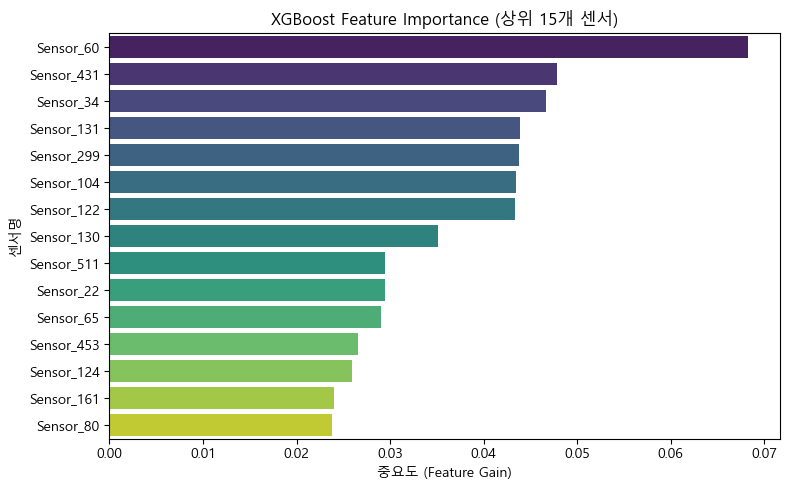

,Sensor,Importance
0,Sensor_60,0.068287
6,Sensor_431,0.047807
27,Sensor_34,0.046694
33,Sensor_131,0.043938
13,Sensor_299,0.043778
1,Sensor_104,0.043461
21,Sensor_122,0.043314
11,Sensor_130,0.035125
2,Sensor_511,0.029495
8,Sensor_22,0.029465


In [41]:
# =======================
# XGBoost Feature Importance
# =======================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# XGB 모델에서 feature importance 추출
feature_importance = model = results["XGB"]
xgb_model = models["XGB"]
xgb_model.fit(X_train_res, y_train_res)

# 중요도 추출
importances = xgb_model.feature_importances_
feature_names = X_sel.columns

importance_df = pd.DataFrame({
    'Sensor': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 상위 15개 센서만 시각화
plt.figure(figsize=(8, 5))
sns.barplot(data=importance_df.head(15), x='Importance', y='Sensor', palette='viridis')
plt.title("XGBoost Feature Importance (상위 15개 센서)")
plt.xlabel("중요도 (Feature Gain)")
plt.ylabel("센서명")
plt.tight_layout()
plt.show()

# 전체 중요도 테이블 보기
importance_df.head(20)
